In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint 
from skopt import gp_minimize
from skopt.plots import plot_convergence

%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use('seaborn-darkgrid')
c_cycle=("#ea5415","#005192","#ffdf00","#1d7a21","#88593b","#737061")

/var/folders/ng/g9bjmgc9637ckzqml4dq46140000gn/T/ipykernel_28748/811665391.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [2]:
spaces = [
    (-1.0, 1.0), #s0
    (-1.0, 1.0), #s1
    (-1.0, 1.0), #s2
    (-1.0, 1.0), #c0
    (-1.0, 1.0), #c1
    (-1.0, 1.0) #c2
]

/Users/common/anaconda3/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


res.x: [-0.2560101125588886, -0.21694053480096454, -0.10445518961100797, 0.1081407841759423, 0.0483952085789876, -0.09308510970737793]
res.fun: 0.585


<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

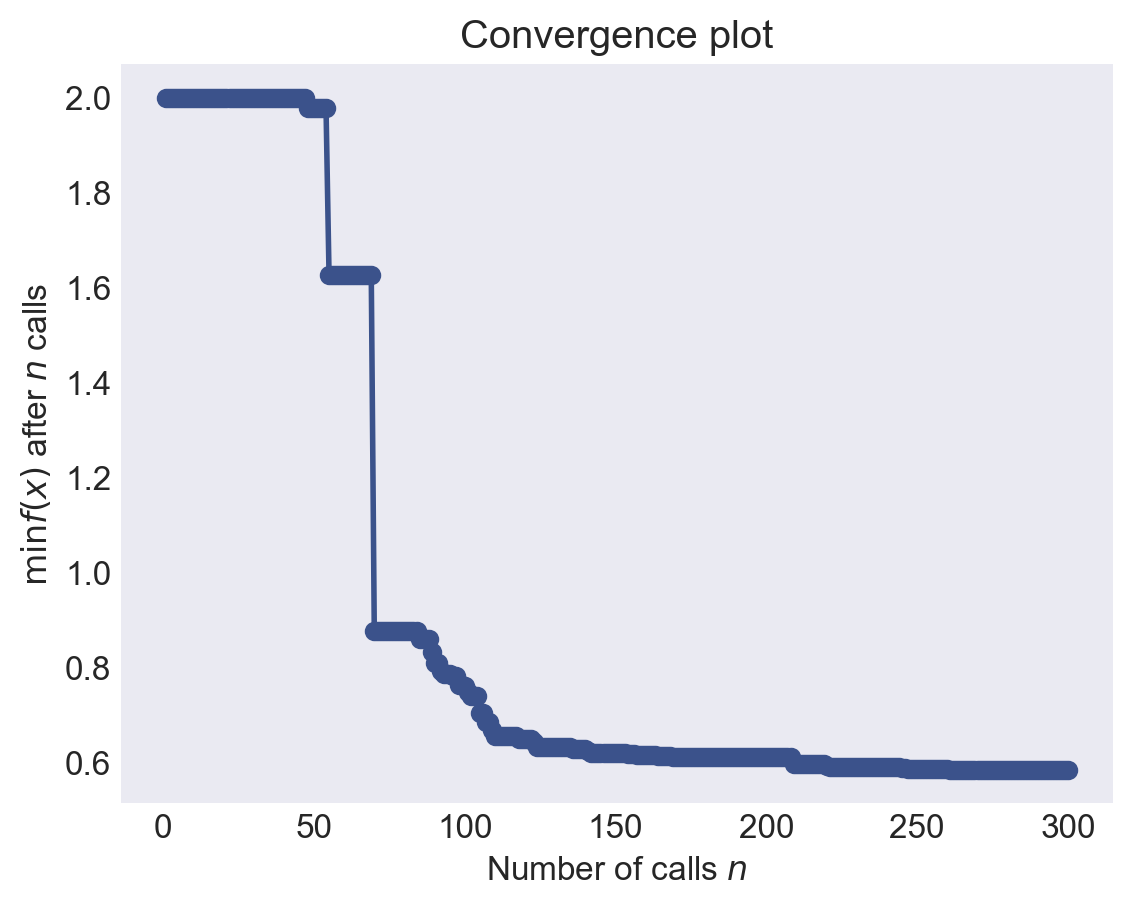

In [3]:
def f(coeffs):

    def sin_series(coeffs, period, x):
        value_at_x = 0
        for i in range(len(coeffs)):
            value_at_x += coeffs[i]*np.sin(np.pi*(i+1)*x/period)
        return value_at_x

    def cos_series(coeffs, period, x):
        value_at_x = 0
        for i in range(len(coeffs)):
            value_at_x += coeffs[i]*np.cos(np.pi*(i+1)*x/period)
        return value_at_x

    # a curve through (0,0) and (goal_x, goal_y)
    def func(sin_coeff, cos_coeff, goal_x, goal_y, x):
        return goal_y/goal_x*x + sin_series(sin_coeff, goal_x, x) + cos_series(cos_coeff, goal_x, x)

    # 1st-derivertive of func
    def d_func(sin_coeff, cos_coeff, goal_x, goal_y, x):
        new_sin_coeff = [] 
        new_cos_coeff = [] 
        for i in range(len(sin_coeff)):
            new_sin_coeff.append(sin_coeff[i]*(i+1)*np.pi/goal_x)
        for i in range(len(cos_coeff)):
            new_cos_coeff.append(-cos_coeff[i]*(i+1)*np.pi/goal_x)
        return goal_y/goal_x + cos_series(np.array(new_sin_coeff),goal_x,x) + sin_series(np.array(new_cos_coeff),goal_x,x)

    #2nd-derivertive of func
    def d2_func(sin_coeff, cos_coeff, goal_x, goal_y, x):
        new_sin_coeff = [] 
        new_cos_coeff = [] 
        for i in range(len(sin_coeff)):
            new_sin_coeff.append(-sin_coeff[i]*(i+1)*(i+1)*np.pi*np.pi/(goal_x*goal_x))
        for i in range(len(cos_coeff)):
            new_cos_coeff.append(-cos_coeff[i]*(i+1)*(i+1)*np.pi*np.pi/(goal_x*goal_x))
        return sin_series(np.array(new_sin_coeff),goal_x,x) + cos_series(np.array(new_cos_coeff),goal_x,x)

    def extend_cos_coeff(cos_coeff):
        cos_coeff_odd  = sum(cos_coeff[0::2])
        cos_coeff_even = sum(cos_coeff[1::2])    
        if len(cos_coeff)%2==0:
            cos_coeff.append(-cos_coeff_odd)
            cos_coeff.append(-cos_coeff_even)
        else:
            cos_coeff.append(-cos_coeff_even)
            cos_coeff.append(-cos_coeff_odd)
        return np.array(cos_coeff)

    def equation_of_motion(state, simulation_time, sin_coeff, cos_coeff, x1, y1, m, mu, k, g):
        x, v = state
        fp   = d_func(sin_coeff, cos_coeff,x1,y1,x)
        f2p  = d2_func(sin_coeff, cos_coeff,x1,y1,x)
        temp = 1.0/(1+fp*fp)
        kp   = k/m
        mufp = mu+fp

        dxdt = [v, - temp*mufp*f2p*v*v - temp*kp*(1+mufp*fp)*v - temp*mufp*g]
        return dxdt

    def get_result(anser, goal_x, goal_y, sin_coeff, cos_coeff, simulation_time):
        temp   = anser[anser[:,0]<goal_x]
        trajectory_x = temp[:,0]
        trajectory_y = np.array( list(map(lambda u: func(sin_coeff, cos_coeff, goal_x, goal_y, u), trajectory_x)) )
        time = simulation_time[:len(temp)]
        return trajectory_x, trajectory_y, time

    #parameters
    g      = 9.8 # gravity constant [m/s^2]
    k      = 0.   # air resistance coefficient
    mu     = 0.   # friction constant coefficient
    mass   = 1   # mass [kg]
    initial_state = [0.0, 0.0] #x0,v0

    simulation_time = np.linspace(0, 2, (2*1000)+1) # time array

    #define slope
    goal_x  = 1
    goal_y  = -1

    sin_coeff = coeffs[:int(len(coeffs)/2)]
    cos_coeff = coeffs[int(len(coeffs)/2):]
    cos_coeff = extend_cos_coeff(cos_coeff)

    #solve equation of motion
    phase_space      = odeint(equation_of_motion, initial_state, simulation_time, args=(sin_coeff, cos_coeff, goal_x, goal_y, mass, mu, k, g))
    xpos, ypos, tpos = get_result(phase_space, goal_x, goal_y, sin_coeff, cos_coeff, simulation_time)
    return tpos[-1]


res = gp_minimize(f, spaces, acq_func="gp_hedge", n_calls=300, random_state=1)
print(f'res.x: {res.x}')
print(f'res.fun: {res.fun}')
plt.rcParams["font.size"] = 12
plot_convergence(res)  

In [13]:
def extend_cos_coeff(cos_coeff):
    cos_coeff_odd  = sum(cos_coeff[0::2])
    cos_coeff_even = sum(cos_coeff[1::2])    
    if len(cos_coeff)%2==0:
        cos_coeff.append(-cos_coeff_odd)
        cos_coeff.append(-cos_coeff_even)
    else:
        cos_coeff.append(-cos_coeff_even)
        cos_coeff.append(-cos_coeff_odd)
    return np.array(cos_coeff)

def func(sin_coeff, cos_coeff, goal_x, goal_y, x):
    return goal_y/goal_x*x + sin_series(sin_coeff, goal_x, x) + cos_series(cos_coeff, goal_x, x)

def sin_series(coeffs, period, x):
    value_at_x = 0
    for i in range(len(coeffs)):
        value_at_x += coeffs[i]*np.sin(np.pi*(i+1)*x/period)
    return value_at_x

def cos_series(coeffs, period, x):
    value_at_x = 0
    for i in range(len(coeffs)):
        value_at_x += coeffs[i]*np.cos(np.pi*(i+1)*x/period)
    return value_at_x
    
x1 = 1
y1 = -1

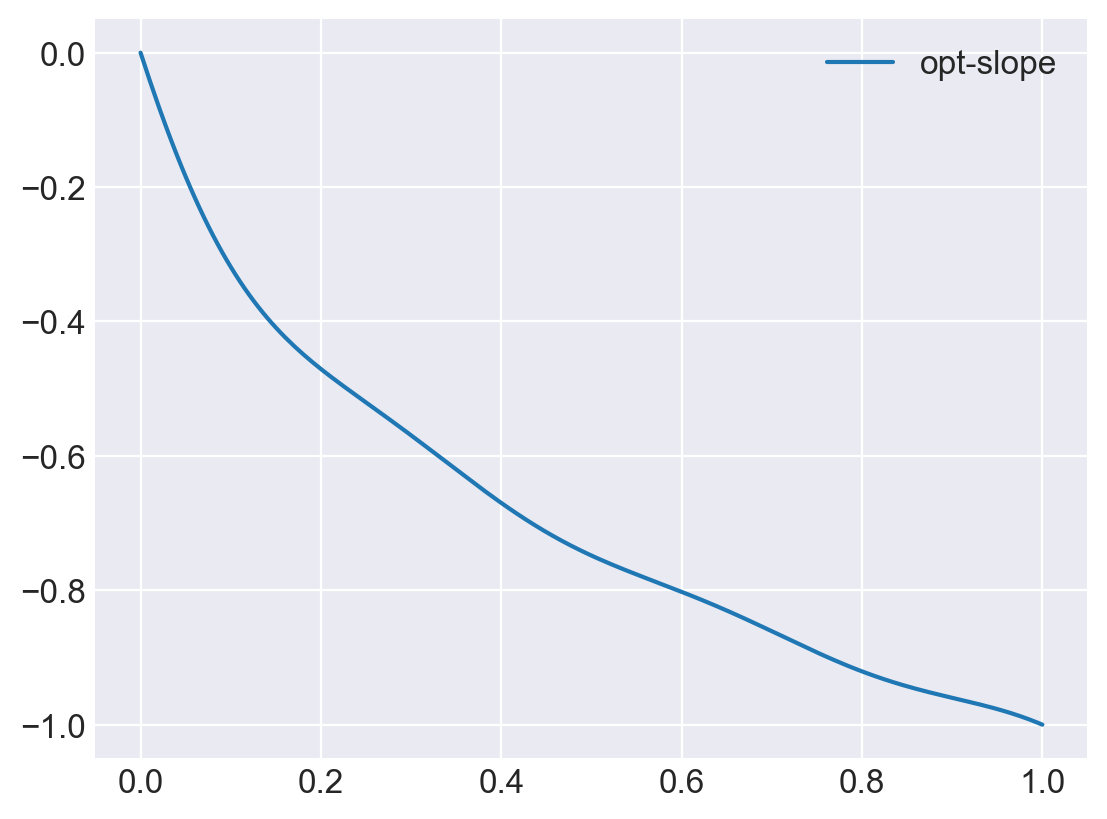

In [15]:
coef = list(res.x)
sn = np.array(coef[:int(len(coef)/2)])
cn = np.array(coef[int(len(coef)/2):])
cn = extend_cos_coeff(list(cn))
x  = np.linspace(0,x1,200)
f  = np.array( list(map(lambda u: func(sn,cn,x1,y1,u),    x)) )
#plt.plot(cx,cy,label='steepest')
plt.plot(x, f, label="opt-slope")
plt.legend(loc='best')